In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve

import optuna

import xgboost as xgb
warnings.filterwarnings('ignore')
# pip --default-timeout=1688 install optuna -i  http://pypi.douban.com/simple/ --trusted-host pypi.douban.com


In [6]:
data = pd.read_csv(r'bank-full.csv')

In [7]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


我们看到这里的数据和特征名存在一些特殊字符，先将这些特殊符号去除。

In [10]:
data = data.rename(columns=lambda x: x.replace("'","").replace('"','')).replace(" ","")
for col in data.select_dtypes( 'object').columns:
    data[col] = data[col].apply(lambda x:x.replace("'","").replace('""','').replace('"',''))


同时将index和age分开：

In [18]:
# data['index,age'] = data['index,age'].str.split(',',expand=True)[1]
# data.rename(columns={'index,age':'age'},inplace=True)
# data_clean = data.copy()
# data_clean.age = data_clean.age.astype('int8')


In [21]:
data_clean=data.copy()

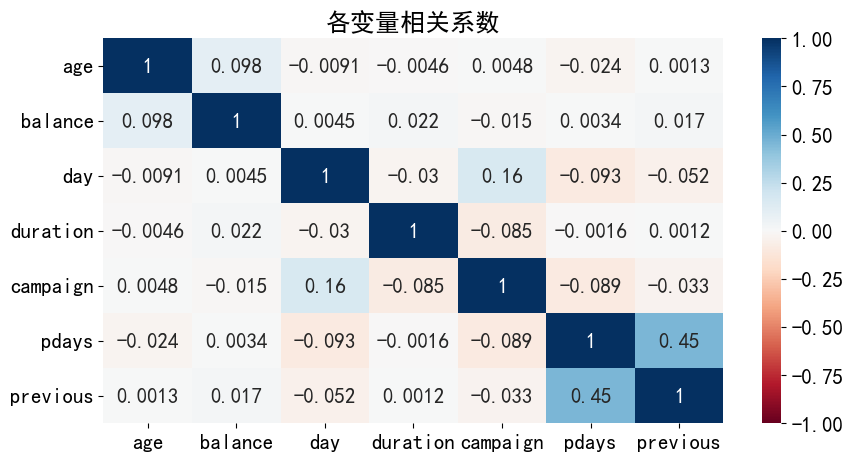

In [22]:
font = {'family':'SimHei','size':'15'}
plt.rc('font',**font)
plt.rc('axes',unicode_minus='False')
plt.figure(figsize = (10,5))
corr_matrix = data_clean.corr()
sns.heatmap(corr_matrix, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('各变量相关系数')
plt.show()


分析结果
从协方差矩阵来看，仅有pdays和previous之间有较强的相关性，直接的意思是越久没联系的客户，过去联系的次数越多。出现这一情况可能是由于当下银行更多的将精力放在挖掘新客户上。而对于其他特征，仅从协方差矩阵很难得到什么实质信息。

# 数据探索性分析
在这一部分，笔者将对各个特征的分布情况，以及各个特征对于用户是否购买的影响情况两方面着手进行探索性分析。

定义分布直方图绘图函数方便后续分析：

In [23]:
def dist_plot(data, col, title):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col, data=data, ax=ax[0],color = "#1D8EF5")
    ax[0].set(yticks=[])
    sns.histplot(x=col, data=data, ax=ax[1],color = "#33AAFF", edgecolor="#1D1EA2")
    ax[1].set_xlabel(col, fontsize=16)
    plt.axvline(data[col].mean(), color='darkgreen', linestyle='--',linewidth=2.2, label='mean=' + str(np.round(data[col].mean(),1)) )
    plt.axvline(data[col].median(), color='red', linestyle='--',linewidth=2.2, label='median='+ str(np.round(data[col].median(),1)) )
    plt.axvline(data[col].mode()[0], color='purple', linestyle='--',linewidth=2.2, label='mode='+ str(np.round(data[col].mode()[0],1)) )
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
    plt.tight_layout()
    plt.show()



## 各个数值型特征的分布分析：
### 年龄的分布情况

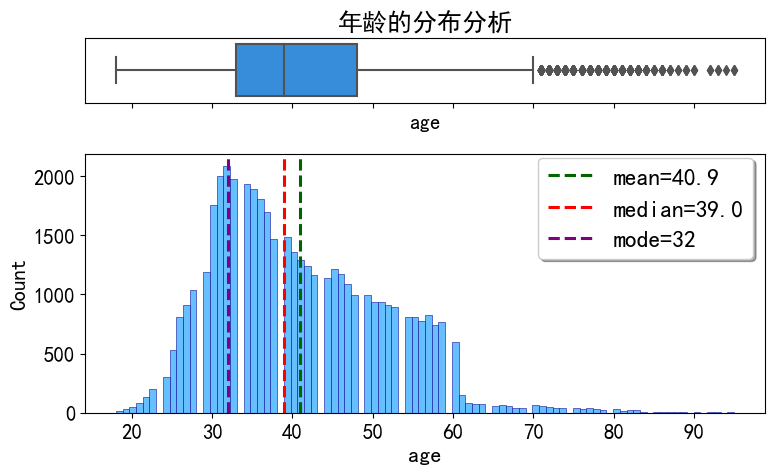

In [24]:
dist_plot(data_clean,'age','年龄的分布分析')


客户年龄集中在32岁，整体呈现右偏态分布。

### 收支情况分布

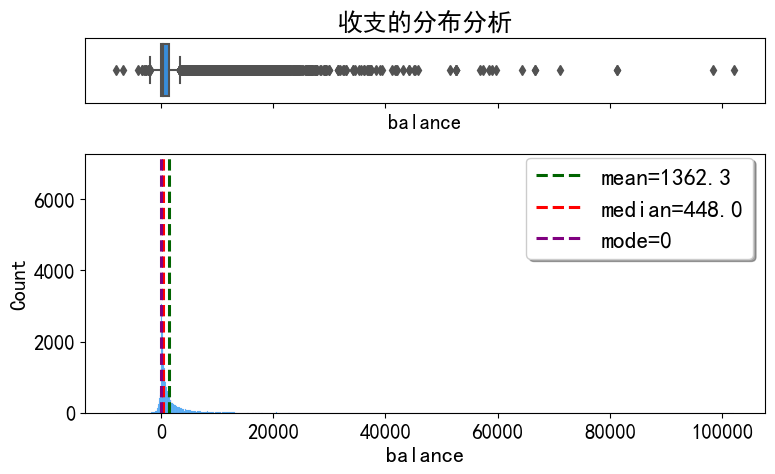

In [25]:
dist_plot(data_clean,'balance','收支的分布分析')


客户的收支情况呈现出明显的长尾分布。

### 联系时长的分布情况

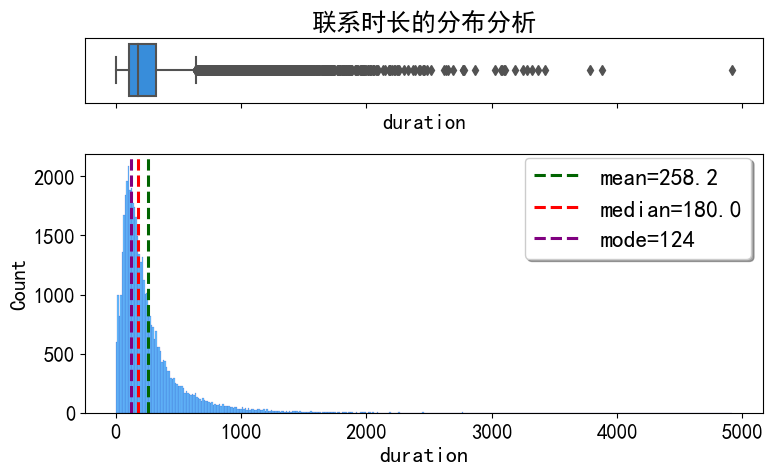

In [26]:
dist_plot(data_clean,'duration','联系时长的分布分析')


典型的长尾分布，大多数客户的联系时长在2分钟左右。

### 距离上次联系天数的分布

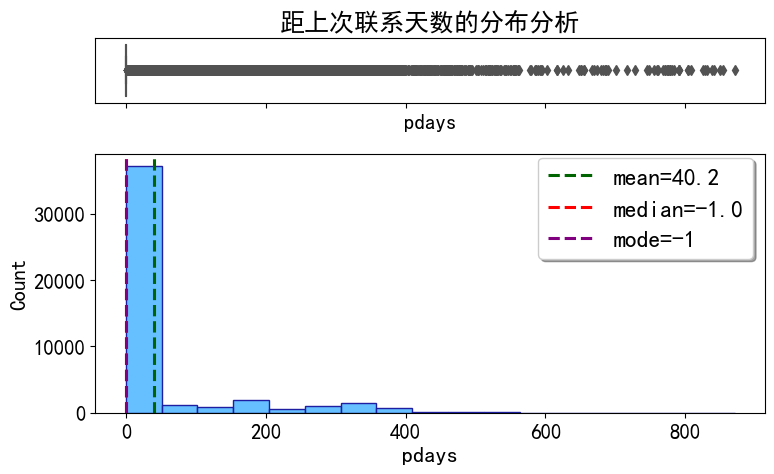

In [27]:
dist_plot(data_clean,'pdays','距上次联系天数的分布分析')


可以看到这里大量出现了-1，此处的-1为从未联系过的新客户，即在本次活动中，有大量客户是以前从未联系过的。这一现象符合之前协方差矩阵分析中得到的结论：银行在本次活动中以新客户为重点营销目标。

给这些新客户单独加上标签，方便后续进行分析。

In [28]:
data_clean['new_customer'] = data.pdays.apply(lambda x : 1 if x == -1 else 0)


小结：
从以上数据分布分析中，我们了解到该行客户的年龄集中在32岁，并且大部分客户账面余额为0，本次活动中客户经理们集中对新客户开展营销。

## 探索不同变量对是否购买存款的影响
在这一部分，笔者将探索每一个特征对于是否购买存款的影响。

定义一个饼图绘制函数方便后续绘图分析

In [29]:
def pie_plot(data,col,title,figsize = (20,20),height = 4,width = 4):
    plt.figure(figsize = figsize)
    plt.suptitle(title)
    row = data_clean[col].unique().tolist()
    length = len(row)
    for i in range(length):
        plt.subplot(width,height,i+1).set_title(row[i])
        plt.pie( data[data_clean[col] == row[i]].y.value_counts(),
                 labels = ['no','yes'],
                explode = [0,0.2],
                colors = ['#66CCCC','#FF6666'],
                autopct = '%.2f%%'  
               )
plt.show()


### 工作情况会否影响是否存款？

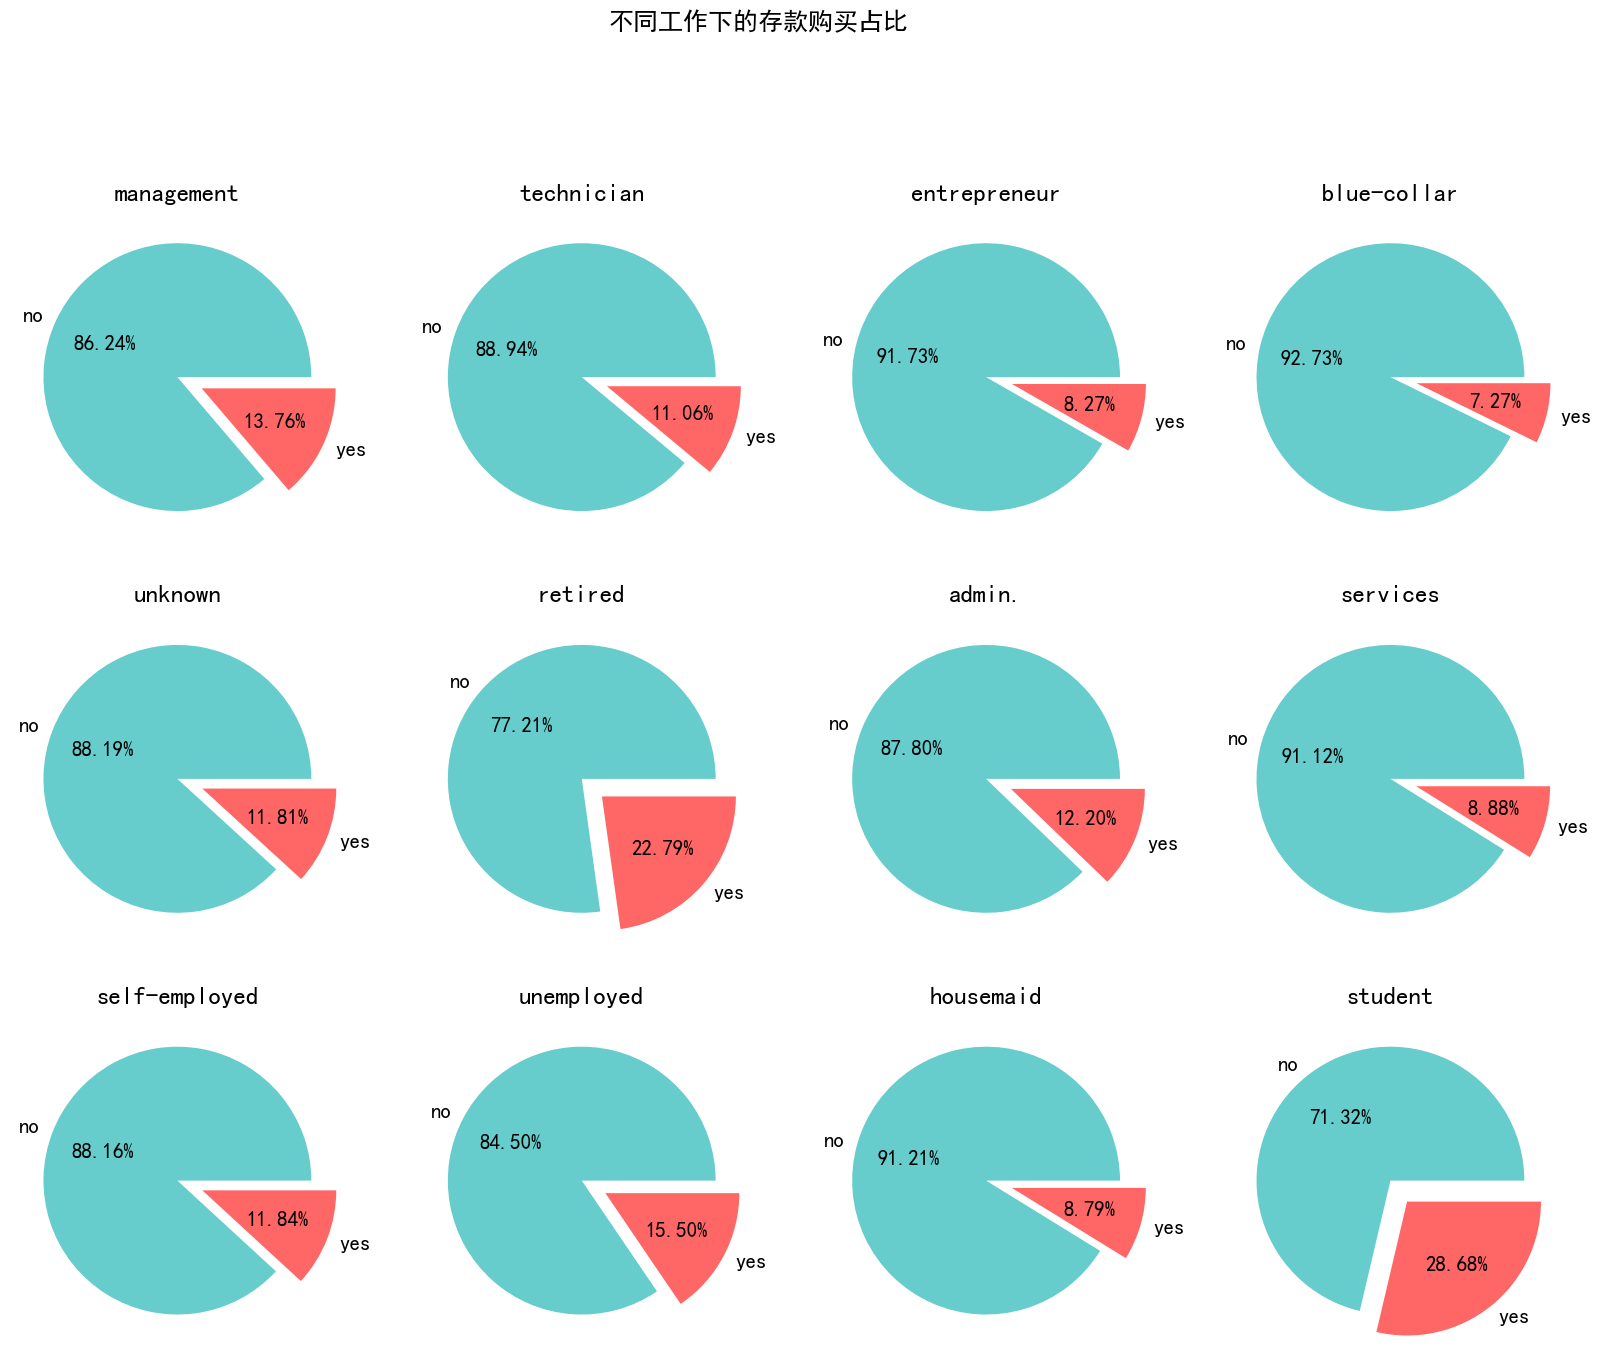

In [30]:
pie_plot(data_clean,'job','不同工作下的存款购买占比')


分析结果：
无固定收入的群体，包括学生，退休人员，失业人员的存款购买意愿最高。在选择存款销售对象时可以优先考虑这些群体。高收入人群，包括经理，管理者的存款认购意愿要高于低收入人群，包括服务员，家庭主妇和蓝领。
猜想：
从笔者的业务经验理解，高收入人群在日常开销外有更多的可支配资产，而低收入人群则需要更多的流动性去满足日常开支，因此对于存款的认购意愿也不高。


### 婚姻状况会否影响存款购买

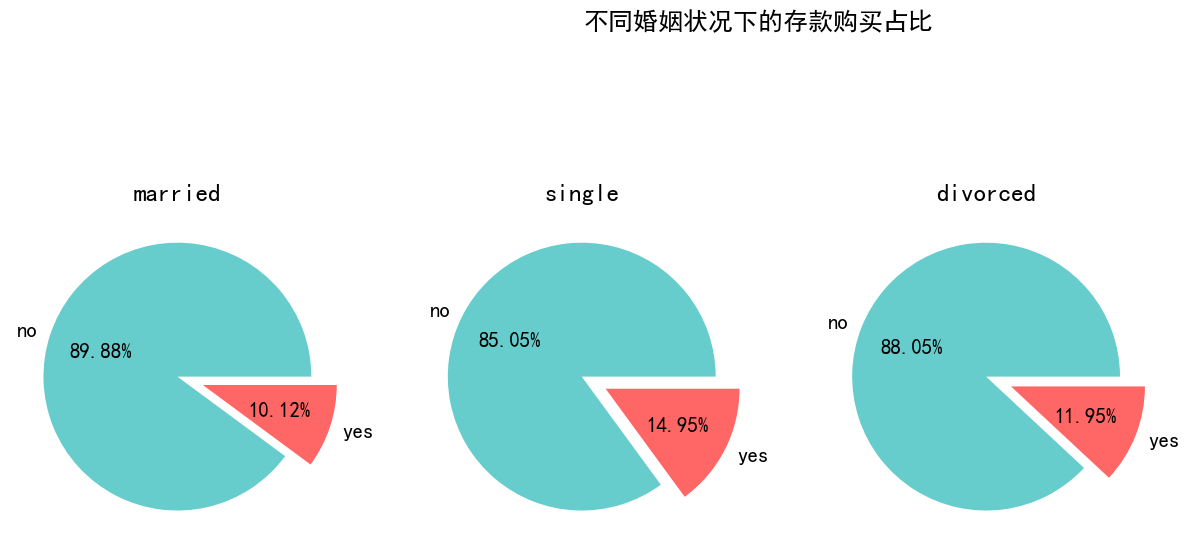

In [31]:
pie_plot(data_clean,'marital','不同婚姻状况下的存款购买占比')

分析结果：
不同婚姻状况下，单身群体的存款意愿高于已婚和离婚的。
猜想：
一方面可能是由于单身群体只需要照顾自己，其满足日常开支后剩余的流动性要大于已婚和离婚人士，因此愿意将一部分流动性转化为存款。
另一方面可能是由于单身群体需要有存款积蓄为今后结婚做储备，所以其存款意愿较高。


### 教育水平会否影响存款购买


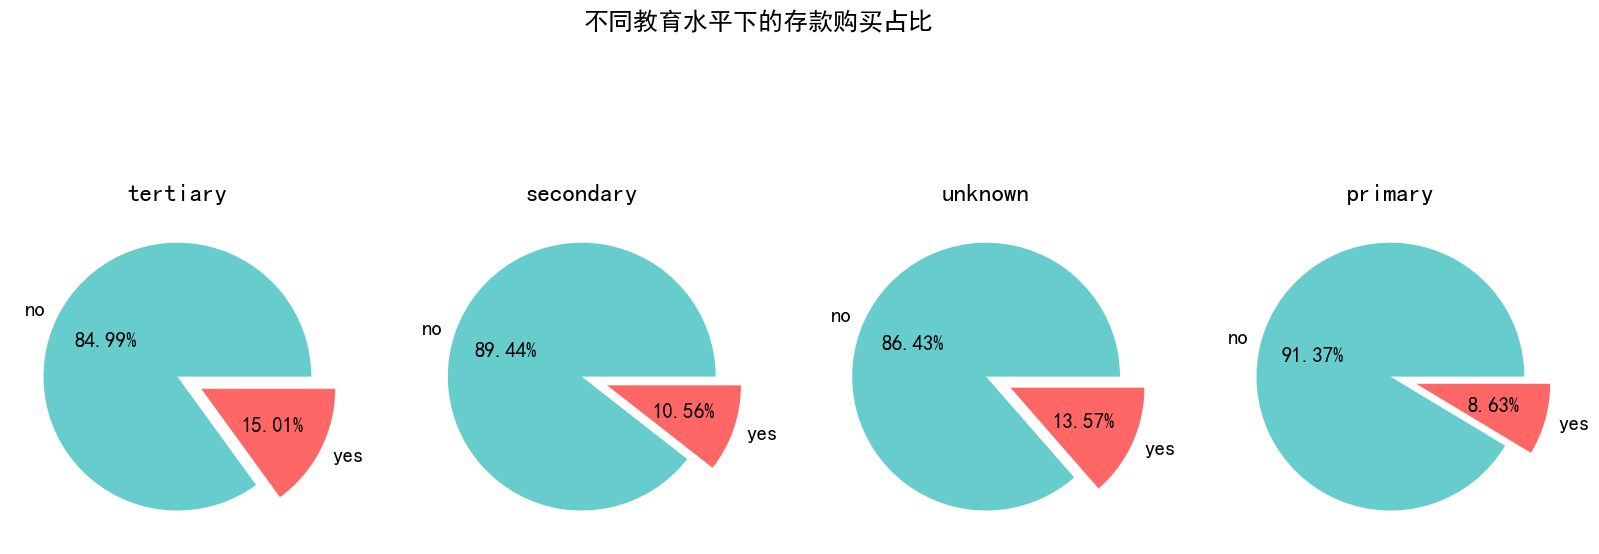

In [32]:
pie_plot(data_clean,'education','不同教育水平下的存款购买占比')

分析结果
存款意愿随着教育水平（小学水平，中学水平，高中水平）的升高而上升
猜想
更高教育水平的客户可能有着更好的理财投资观念，从而对存款的接受度会更高一些。


### 债务，房贷，个贷会否影响存款购买

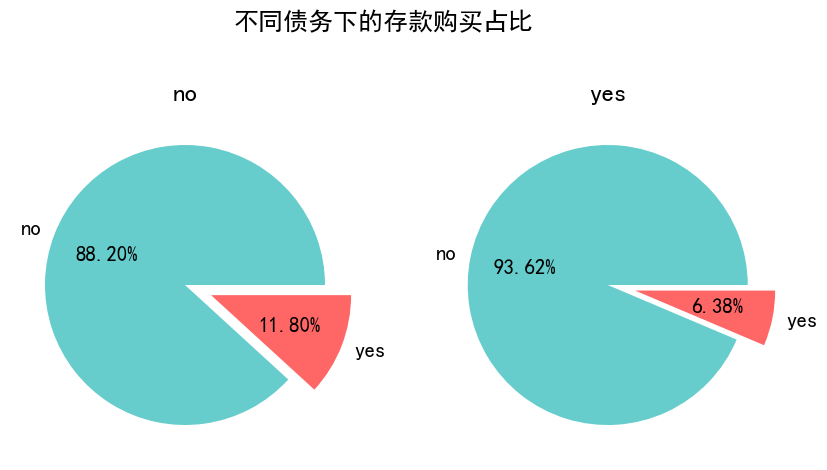

In [33]:
pie_plot(data_clean,'default','不同债务下的存款购买占比',(10,10),height = 2, width = 2)

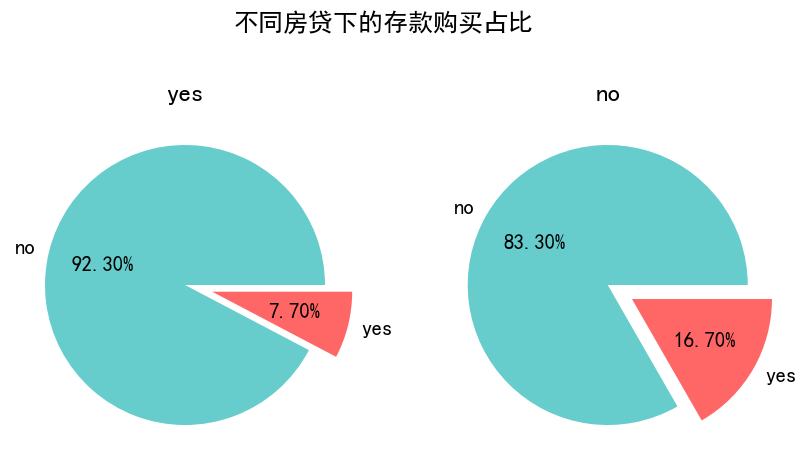

In [34]:
pie_plot(data_clean,'housing','不同房贷下的存款购买占比',(10,10),height = 2, width = 2)


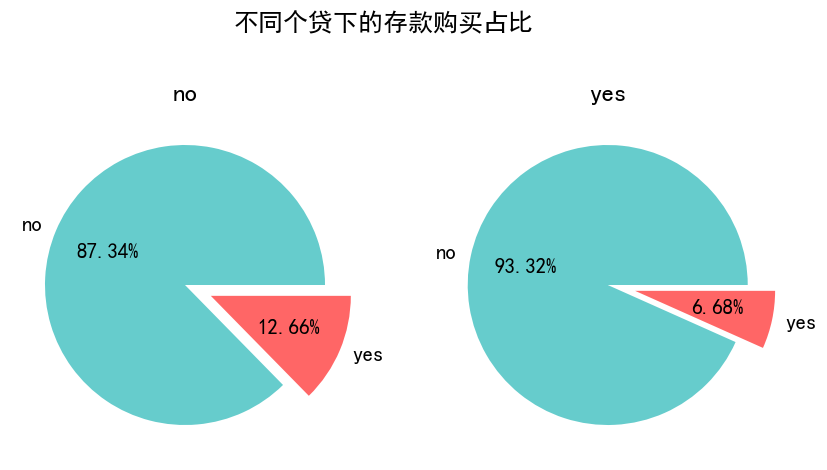

In [35]:
pie_plot(data_clean,'loan','不同个贷下的存款购买占比',(10,10),height = 2, width = 2)

分析结果：
有负债的客户群体存款意愿显著低于无负债的客户群体。
猜想：
有负债的群体需要流动性去偿还利息，然而存款的利息收入显然无法抵补负债利息支出，因此存款对于有负债的群体吸引力会小很多。


### 聊天时长对购买的影响

在电话营销环节，时长越长的电话，营销人员和客户的博弈机会越多，也就更有可能吸引客户购买产品。

所以，我们也需要考虑时长对于营销成功性的影响。在对于时长的探索中，笔者将先观察时长是否会对营销成功率产生影响。如果有影响，笔者会尝试探索如何提升联系时长。

对联系时长进行分桶，以25%，50%，75%为节点将联系时长分为四桶，分别是
[0,103]，[103,180]，[180.319]，[319,4918]（单位：秒），并且将各个桶标记为useless（无效电话）,useful（有效电话）,good（优良电话）,excellent（卓越电话）


In [40]:
data_clean['duration'].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

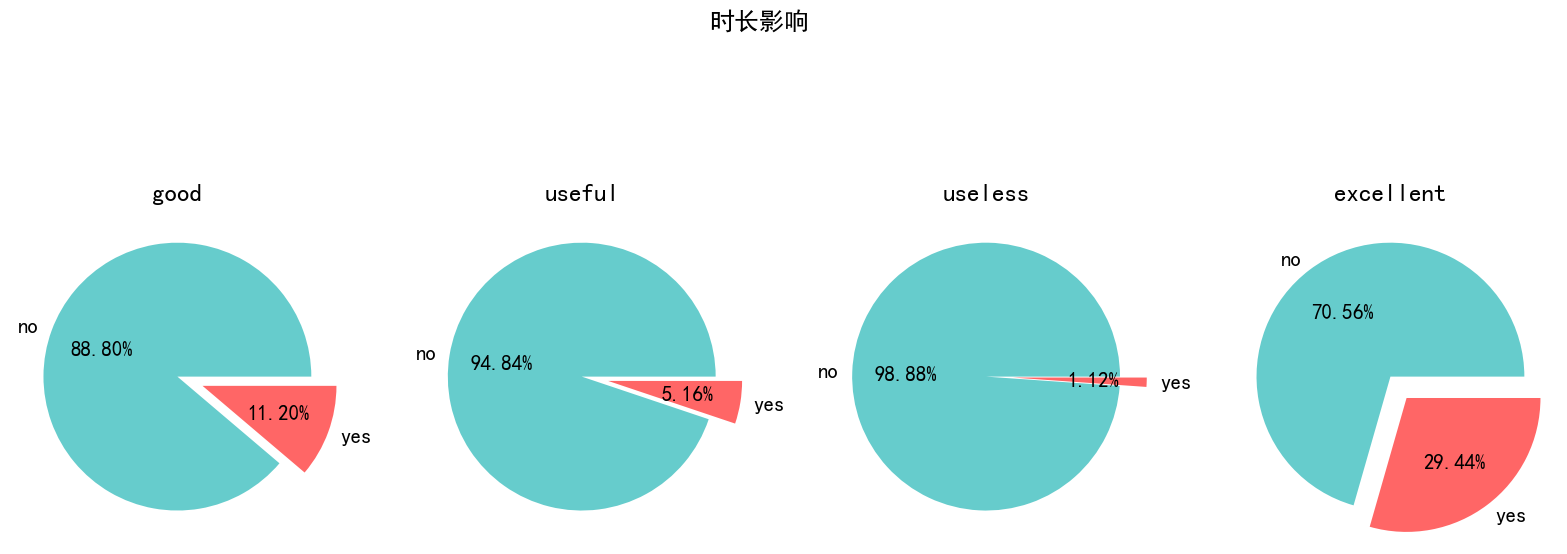

In [41]:
data_clean['duration_label'] = pd.qcut(data_clean.duration,4,labels=['useless','useful','good','excellent'])
pie_plot(data_clean,'duration_label','时长影响')


分析结果
拨打的无效电话中仅有1%的客户愿意购买存款，而随着联系时长的增加，愿意购买存款的客户比率显著性升高。
猜想
以笔者的从业经验出发，客户经理的日常营销中有两个因素会显著影响电话时长。其一是客户当下是否繁忙，其二是客户与客户经理的信任度如何。
大部分客户在客户经理还未说明来意时就直接挂断，这也就构成了无效电话极低的营销成功率。如果在客户空闲的时候拨打电话，客户经理就会有机会向客户介绍产品，其中一部分客户并未与客户经理建立信任关系，即便听完了产品的介绍，也没有选择购买，这就构成了上图的有效电话部分。另一部分客户早先就和客户经理建立的不错的信任度，此时所聊的内容并不只是产品本身，还包含了朋友间的问候，这部分客户将有很大的意愿购买相关产品，这也就构成了优良电话和卓越电话的部分。
因为本次数据的数据集仅包含了本次活动内同客户的联系，也就很难量化客户与客户经理的信任度关系。因此笔者在这里将提升时长的重点放在客户是否繁忙上。


### 绘制客户从周一到周日的电话时长分布情况


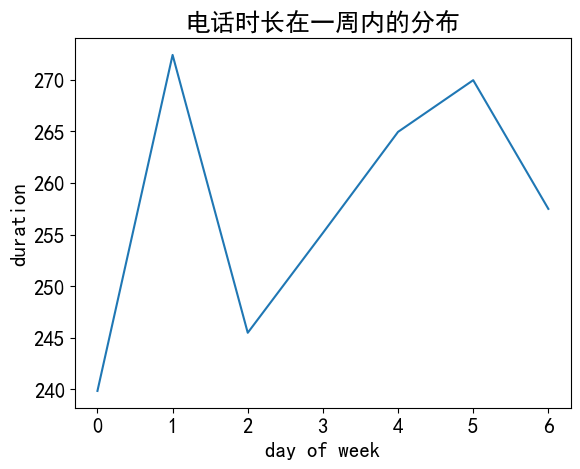

In [42]:
data_clean['date'] = '2011'+'-' + data_clean.month +'-'+ data_clean.day.astype('string')
data_clean['date'] = pd.to_datetime(data_clean['date'])
data_clean['weekday'] = data_clean['date'].dt.weekday

plt.plot(data_clean.groupby('weekday').mean('duration')['duration'])
plt.title('电话时长在一周内的分布')
plt.xlabel('day of week')
plt.ylabel('duration')
plt.show()


这里横轴的0代表周日

分析结果：
客户在周一相对空闲，周二明显降低，周三到周五稳步提升，双休日开始下降。
猜想：
工作日尽量避开周二联系重要客户
进一步地，观察不同工作情况的联系时长变化

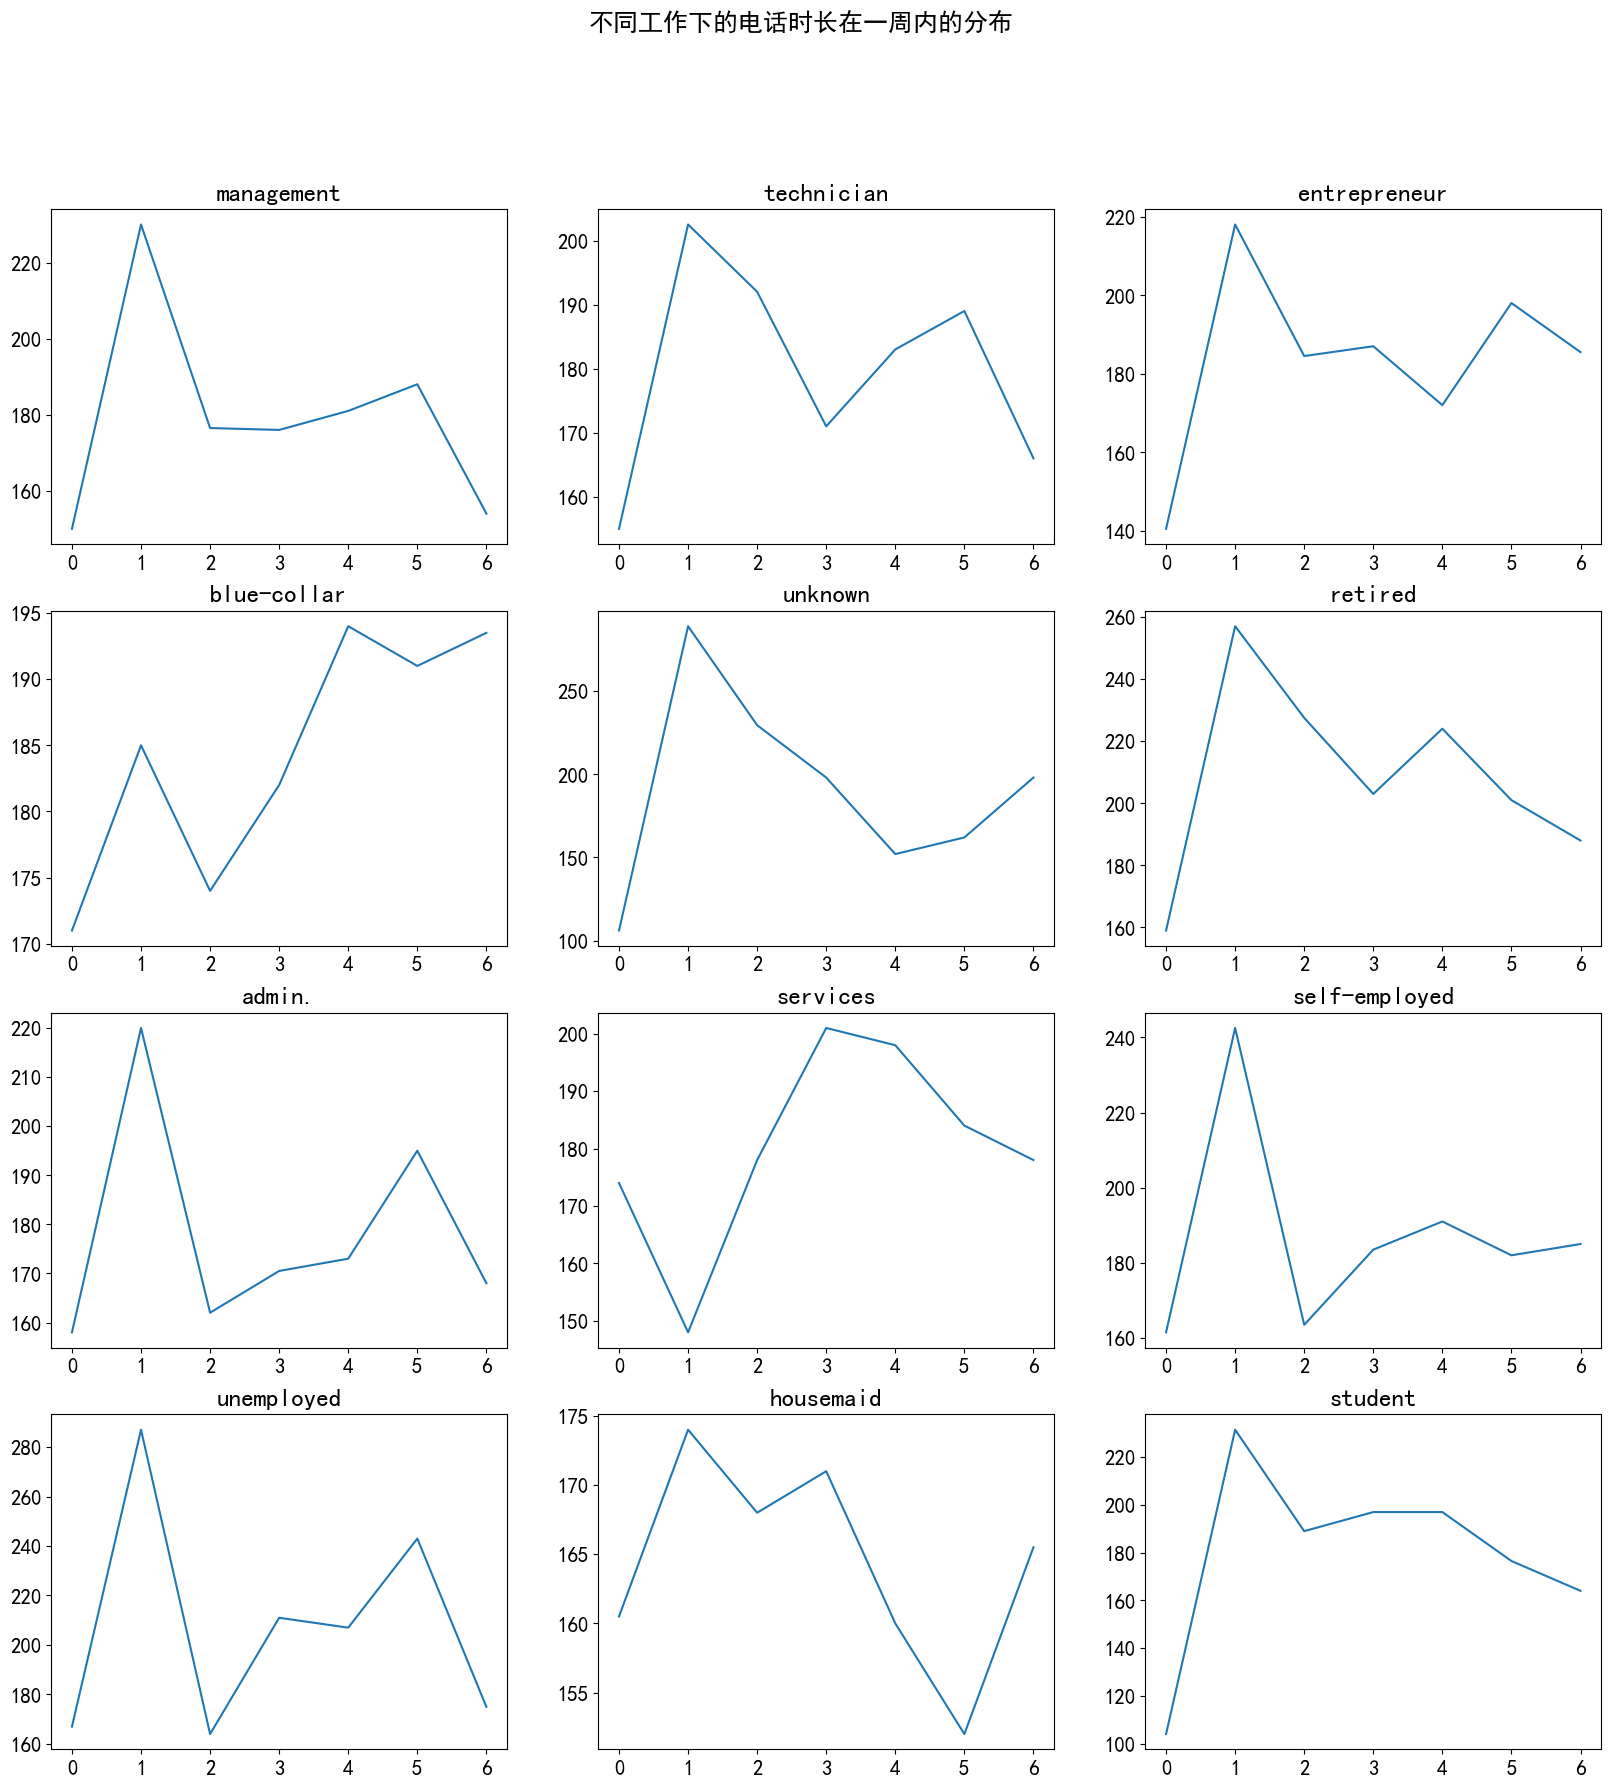

In [43]:
plt.figure(figsize = (20,20))
plt.suptitle('不同工作下的电话时长在一周内的分布')
row = data_clean['job'].unique()

for i in range(len(row)):
    plt.subplot(4,3,i+1).set_title(row[i])
    plt.plot(data_clean[data_clean['job'] ==row[i]] .groupby('weekday').median('duration')['duration'])

plt.show()


分析结果：
除家庭主妇外所有工种的客户在周日的联系时长均达到最低。除了服务员和蓝领以外的所有工种在周一的联系时长达到最长，之后在周二下降，周三周四周五维持相对稳定。蓝领和服务员在周三周四的联系时长最长


### 年龄的影响

In [44]:
data_clean['age_cate'] = pd.cut(data_clean['age'], bins=[0, 20, 35, 55, 70, float('Inf')], labels=['0-18','18-35', '35-55', '55-70', '70-95'])


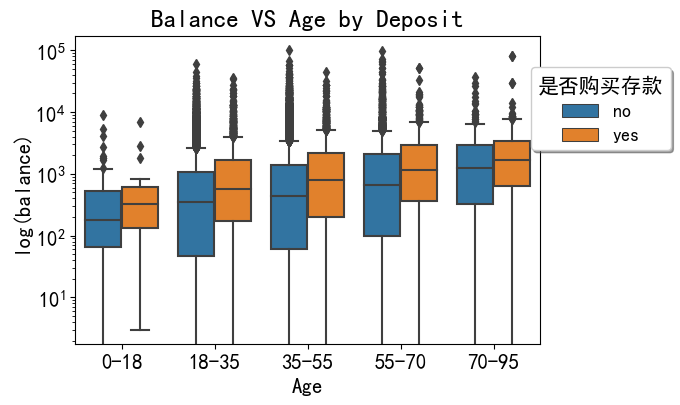

In [46]:
plt.figure(figsize=(6,4))
sns.boxplot(x='age_cate', y='balance', hue='y', data=data_clean)
plt.ylabel('log(balance)')
plt.xlabel('Age')
plt.title('Balance VS Age by Deposit')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.3, 0.6), title='是否购买存款', loc = 'lower right', fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()


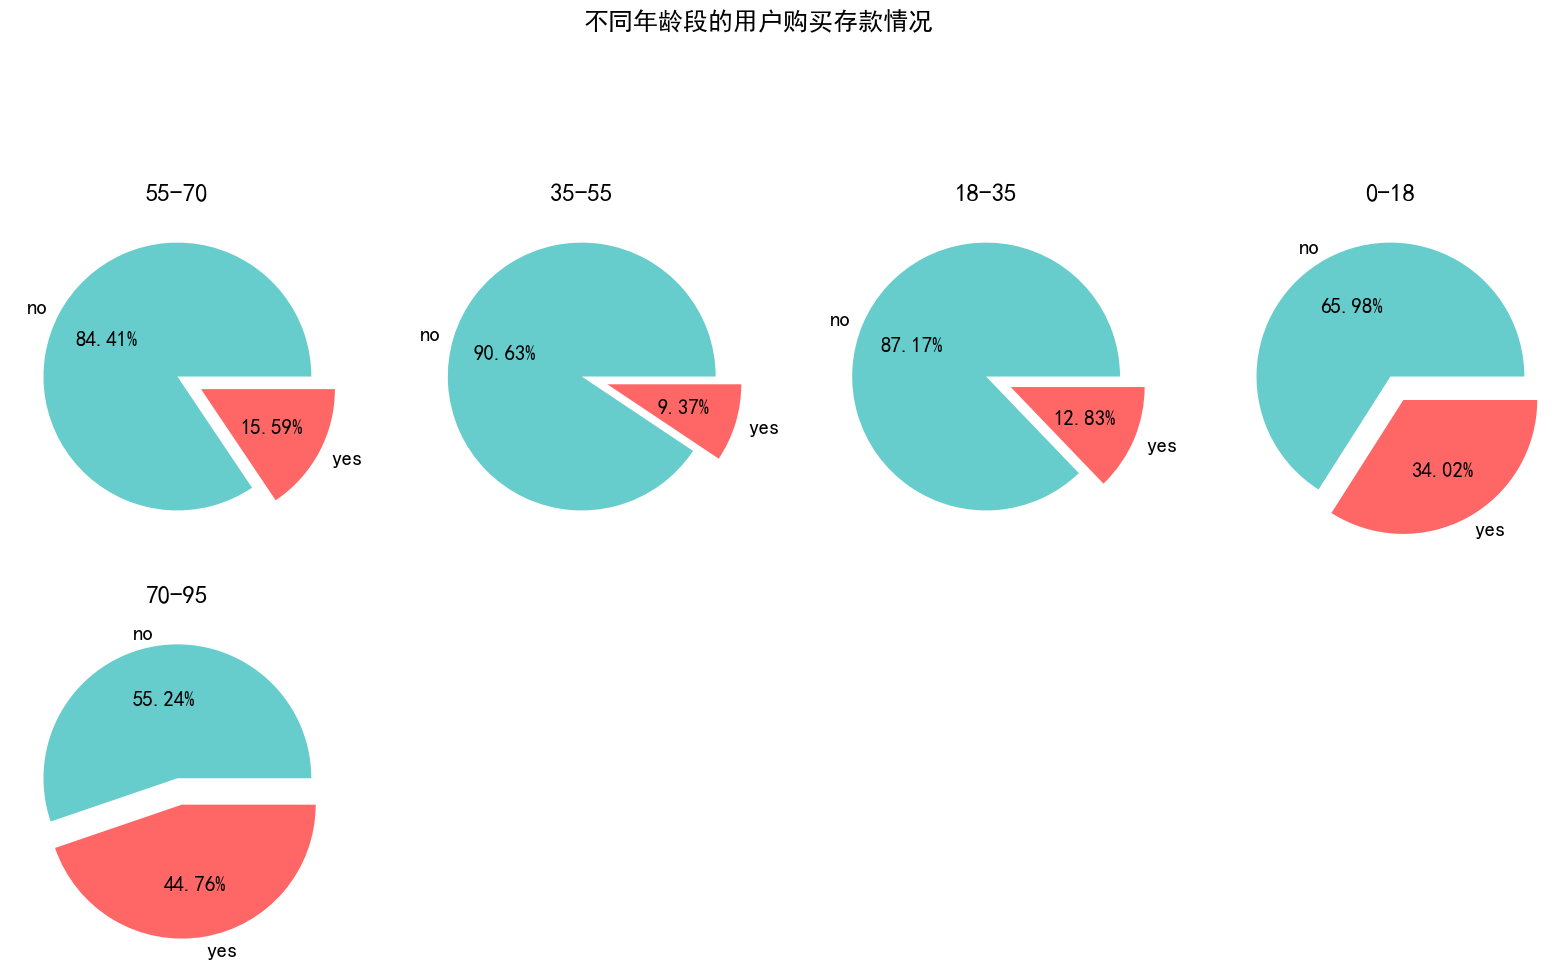

In [47]:
pie_plot(data_clean,'age_cate','不同年龄段的用户购买存款情况')


分析结果
55岁之前的客户存款意愿随着年龄增大而下降，55岁之后的客户存款意愿则随着年龄增大明显上升。其中35-55岁的客户存款意愿最低。
猜想
小于18岁的客户基本由学生组成，消费水平低，可用于存款的资金比例更多。18之后随着结婚等生活压力的增加，日常开支升高，流动性需求升高，导致存款意愿降低。55岁退休之后，消费水平和收入同时下降，需要有稳定性更强的资金来保证生活，因此存款意愿再次升高。



# 潜在客户预测模型建立
在这一部分，笔者将对数据进行特征工程处理，包括非数值变量的编码，异常值的处理。并用XGboost对处理后的数据进行模型训练，评估和预测。


## 预测前的数据处理


In [48]:
data_ml = data_clean.replace(['yes','no'], [1,0])
feature_category = data_ml.select_dtypes('object').columns


In [49]:
data_ml.job.value_counts()


blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

工作特征做独热编码，unknown字段用nan代替

In [50]:
data_clean['job'] = data_clean['job'].replace('unknown', np.nan)

In [51]:
data_ml.age_cate.value_counts()

35-55    23404
18-35    16810
55-70     4413
70-95      487
0-18        97
Name: age_cate, dtype: int64

年龄分桶做序列编码

In [52]:
code = {}
age_encode = {'0-18':0,'18-35':1,'35-55':2,'55-70':3,'70-95':4}
code['age_cate'] = age_encode
data_ml['age_cate'] = data_ml['age_cate'].map(code['age_cate'])


In [54]:
data_ml['marital'].value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

婚姻状况做序列编码

In [55]:
code['marital'] = {'single':0,'married':1,'divorced':2}
data_ml['marital'] = data_ml['marital'].map(code['marital'])


In [56]:
data_ml['education'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

教育水平做序列编码

In [57]:
code['education'] = {'primary':0,'secondary':1,'tertiary':2, 'unknown':np.nan}
data_ml['education'] = data_ml['education'].map(code['education'])
data_ml['contact'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

联系方式做序列编码，unknown用nan代替

In [59]:
code['contact'] = {'telephone':0,'cellular':1, 'unknown':np.nan}
data_ml['contact'] = data_ml['contact'].map(code['contact'])

In [60]:
data_ml['month'].value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

月份做序列编码

In [62]:
code['month']={'jan':0,'feb':1,'mar':2,'apr':3,'may':4,'jun':5,'jul':6,'aug':7,'sep':8,'oct':9,'nov':10,'dec':11}
data_ml['month'] = data_ml['month'].map(code['month'])

In [63]:
data_ml['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

大多数客户在上一次活动中没有联系过，因此将unknown用nan代替。other字段意义不明，这里做删去处理。

In [64]:
data_ml['poutcome'] = data_ml[data_ml['poutcome']!='other']['poutcome']
data_ml['poutcome'] = data_ml['poutcome'].replace('unknown',np.nan)

In [65]:
data_ml.isnull().sum()

age                   0
job                   0
marital               0
education          1857
default               0
balance               0
housing               0
loan                  0
contact           45211
day                   0
month             45211
duration              0
campaign              0
pdays                 0
previous              0
poutcome          38799
y                     0
new_customer          0
duration_label        0
date                  0
weekday               0
age_cate              0
dtype: int64

# 模型训练


## 删去无关特征

In [66]:
data_ml = data_ml.drop(['duration_label','duration','date','day','month'],axis = 1)
data_ml_encoded = pd.get_dummies(data_ml, drop_first=True)

In [67]:
X = data_ml_encoded.drop('y', axis=1)
y = data_ml_encoded['y']

## 训练集，验证集，测试集分离

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state= 666)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, stratify=y_train, random_state= 666)

## 定义目标函数为预测准确率

In [69]:
def objective(trial, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val):
    param = {
        'objective' : 'binary:logistic',
        'eval_metric' : 'auc',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2,0.5),
        'n_estimators': trial.suggest_categorical('n_estimators', [1000,1500,2000,2500,3000,3500]),
        'max_depth': trial.suggest_int('max_depth', 3,10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
    }


    model = xgb.XGBClassifier(**param,use_label_encoder=False)    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False,)   
    preds = model.predict(X_val)
    score = accuracy_score(y_val, preds)

    return score


## 用optuna最大化预测准确率的方式调参

In [70]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("已完成训练次数: ", len(study.trials))
print("最佳结果:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")

hp = study.best_params

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2023-07-15 10:39:29,227] A new study created in memory with name: no-name-f1fba48b-7855-44b1-918d-29909b0f5d08
[I 2023-07-15 10:39:40,332] Trial 0 finished with value: 0.8977147069664578 and parameters: {'lambda': 0.0981454948257054, 'alpha': 0.5258353182537048, 'colsample_bytree': 0.8021346443067183, 'subsample': 0.8, 'learning_rate': 0.016738199691843043, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 0 with value: 0.8977147069664578.
[I 2023-07-15 10:39:43,265] Trial 1 finished with value: 0.8975304091411721 and parameters: {'lambda': 0.914878345448798, 'alpha': 0.7799558521947041, 'colsample_bytree': 0.967622604797932, 'subsample': 1.0, 'learning_rate': 0.1590963838635825, 'n_estimators': 1500, 'max_depth': 5, 'min_child_weight': 20}. Best is trial 0 with value: 0.8977147069664578.
[I 2023-07-15 10:39:47,726] Trial 2 finished with value: 0.8969775156653151 and parameters: {'lambda': 0.03196783247690383, 'alpha': 0.054747048978034826, 'colsample_bytre

[I 2023-07-15 10:41:21,784] Trial 23 finished with value: 0.8973461113158865 and parameters: {'lambda': 0.24586775146320777, 'alpha': 1.4266700975109559, 'colsample_bytree': 0.8847997891169753, 'subsample': 1.0, 'learning_rate': 0.1395399456730867, 'n_estimators': 1500, 'max_depth': 5, 'min_child_weight': 18}. Best is trial 0 with value: 0.8977147069664578.
[I 2023-07-15 10:41:23,673] Trial 24 finished with value: 0.8955031330630299 and parameters: {'lambda': 0.055995597350342395, 'alpha': 0.1510853742515262, 'colsample_bytree': 0.7741635699390543, 'subsample': 1.0, 'learning_rate': 0.3005551645033492, 'n_estimators': 1500, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 0 with value: 0.8977147069664578.
[I 2023-07-15 10:41:30,008] Trial 25 finished with value: 0.8958717287136012 and parameters: {'lambda': 0.18530858027109431, 'alpha': 0.6795460797577424, 'colsample_bytree': 0.9347730335491837, 'subsample': 0.5, 'learning_rate': 0.17138594137482707, 'n_estimators': 2000, 'max_de

[I 2023-07-15 10:44:29,342] Trial 46 finished with value: 0.8969775156653151 and parameters: {'lambda': 0.03639610802295559, 'alpha': 0.20724407520259108, 'colsample_bytree': 0.9757138620023073, 'subsample': 0.7, 'learning_rate': 0.019465784640812236, 'n_estimators': 2000, 'max_depth': 3, 'min_child_weight': 17}. Best is trial 29 with value: 0.8982676004423148.
[I 2023-07-15 10:44:48,402] Trial 47 finished with value: 0.8975304091411721 and parameters: {'lambda': 0.13136157841401305, 'alpha': 1.019428877421379, 'colsample_bytree': 0.6489304294259248, 'subsample': 0.7, 'learning_rate': 0.010137420222613039, 'n_estimators': 3000, 'max_depth': 6, 'min_child_weight': 12}. Best is trial 29 with value: 0.8982676004423148.
[I 2023-07-15 10:44:54,057] Trial 48 finished with value: 0.8971618134906008 and parameters: {'lambda': 0.07881992341389239, 'alpha': 0.08502156825403097, 'colsample_bytree': 0.6763265636174665, 'subsample': 0.8, 'learning_rate': 0.016654204469154117, 'n_estimators': 1000, 

已完成训练次数:  50
最佳结果:
  Value: 0.8982676004423148
  Params: 
    lambda: 0.03736987080248892
    alpha: 0.04834810745816674
    colsample_bytree: 0.5974654955431012
    subsample: 0.6
    learning_rate: 0.015756471852679078
    n_estimators: 3500
    max_depth: 6
    min_child_weight: 20


## 模型拟合

In [71]:
xgb_model = xgb.XGBClassifier(**hp)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=0)


XGBClassifier(alpha=0.04834810745816674, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5974654955431012, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=0.03736987080248892,
              learning_rate=0.015756471852679078, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=20, missing=nan,
              monotone_constraints='()', n_estimators=3500, n_jobs=0,
              num_parallel_tree=1, ...)

In [72]:
y_pred_xgb = xgb_model.predict(X_test)

## 绘制ROC并计算AUC

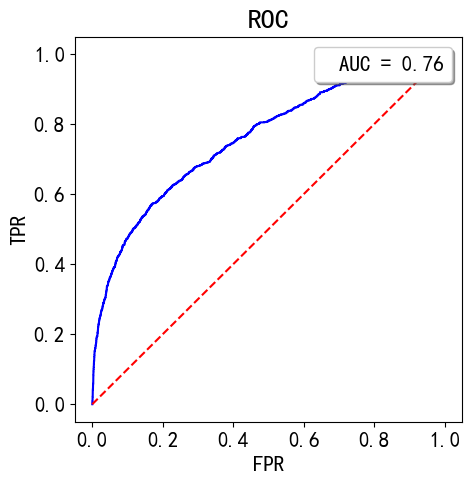

In [79]:
plt.figure(figsize = (5, 5))

probs = xgb_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC',fontsize=20)
plt.ylabel('TPR',fontsize=15)
plt.xlabel('FPR',fontsize=15)
plt.legend(loc = 'upper right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)
plt.show()


In [74]:
confusion_matrix(y_pred_xgb,y_test)


array([[7903,  877],
       [  82,  181]], dtype=int64)

模型结果
从混淆矩阵中看出，当新进入9043个客户时，我们预测其中有1058个客户有存款购买意愿，有192个客户预测正确，查准率达到
192/(77+192) = 71.4%。


# 总结
对于新的一批客户，可以用本模型先进行预测，将预测出的购买意愿高的客户作为重点客户对待。在活动前夕，由客户经理对这批客户做提前触达，建立起双方的信任度，为日后的营销工作打好基础。

客群的联系优先级顺序上，首先联系无负债客群，客群内部按照工作为失业人员，低收入群体，高收入群体以及学历从高到低的顺序进行客户意愿排摸。

在同客户联系的过程中，可根据前文中不同工作的客户在一周内联系时长折现图，选择客户经理当天的目标营销客户，重点在于提高同客户的联系时长。
